In [1]:
!pip install plotly
!pip install lightgbm
!pip install --upgrade pip
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from IPython.display import Image, display
from pandas.tools.plotting import scatter_matrix 
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn import preprocessing
import lightgbm as lgb 
import warnings; warnings.simplefilter('ignore')

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
ERROR: To modify pip, please run the following command:
C:\Users\USER\Miniconda3\envs\py3k\python.exe -m pip install --upgrade pip
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [98]:
df = pd.read_csv(".\\train.csv")

In [59]:
df.head()

,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,Firefox,desktop,False,Windows,9499785259412240342,not available in demo dataset,Europe,Netherlands,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472812272,1.0,1.472812e+09
1,Organic Search,20160902,Chrome,desktop,False,Windows,3696906537737368442,Buenos Aires,Americas,Argentina,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472856874,1.0,1.472857e+09
2,Organic Search,20160902,Chrome,desktop,False,Linux,5688512451361930466,Bengaluru,Asia,India,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472811524,1.0,1.472812e+09
3,Organic Search,20160902,Safari,mobile,True,iOS,9716453263501147451,New Delhi,Asia,India,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472823508,1.0,1.472824e+09
4,Organic Search,20160902,Chrome,desktop,False,Windows,5330453591145100432,Sao Paulo,Americas,Brazil,...,NaN,(not set),NaN,(not provided),organic,NaN,google,1472839619,1.0,1.472840e+09


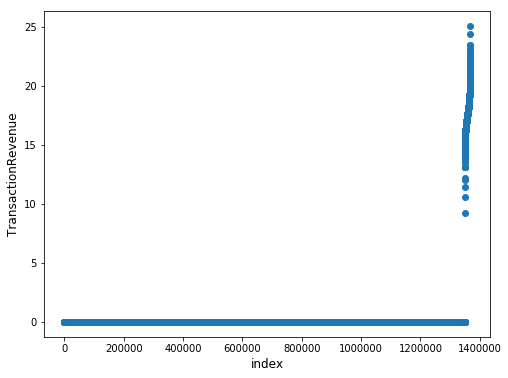

In [41]:
gdf = df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [42]:
nzi = (df["totals.transactionRevenue"]>0).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  18514  and ratio is :  0.010837440153786987
Number of unique customers with non-zero revenue :  16549 and the ratio is :  0.012102769324829435


The dispersion of the 'visitNumber' per session is huge. Therefore, we can use Log and map the feature space to new lower space 
and visualization the data will be easier.

(array([1.30743e+06, 2.53504e+05, 7.69020e+04, 3.49070e+04, 1.81220e+04,
        8.36800e+03, 4.26100e+03, 2.85300e+03, 1.48400e+03, 5.06000e+02]),
 array([0.        , 0.61246834, 1.22493668, 1.83740502, 2.44987336,
        3.0623417 , 3.67481003, 4.28727837, 4.89974671, 5.51221505,
        6.12468339]),
 <a list of 10 Patch objects>)

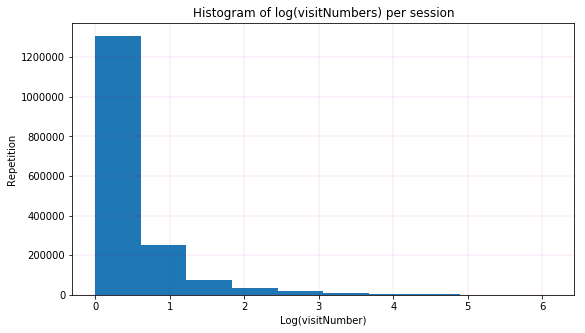

In [43]:
fig,ax = plt.subplots(1,1,figsize=(9,5))
ax.set_title("Histogram of log(visitNumbers) per session")
ax.set_ylabel("Repetition")
ax.set_xlabel("Log(visitNumber)")
ax.grid(color='m', linestyle='-', linewidth=0.1)
ax.hist(np.log(df.visitNumber))

In [44]:
import datetime
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(23, 70, 136, 0.8)')
trace4 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(23, 70, 136, 0.8)')

# Operating system
cnt_srs = df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'mean'])
cnt_srs.columns = ["count", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace5 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(216, 178, 169, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(216, 178, 169, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=2, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [48]:
# Continent
cnt_srs = df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(38, 171, 82, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(38, 171, 82, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(38, 171, 82, 0.6)')

# Sub-continent
cnt_srs = df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'rgba(126, 101, 22, 0.6)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'rgba(126, 101, 22, 0.6)')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'rgba(126, 101, 22, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1000, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



There are a few categorical columns that we need to encode to help with the prediction

In [62]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']

for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[col].values.astype('str')))
    df[col] = lbl.transform(list(df[col].values.astype('str')))

In [92]:
reg_df = df.drop('fullVisitorId', 1)
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 37 columns):
channelGrouping                                 int64
date                                            int64
device.browser                                  int64
device.deviceCategory                           int64
device.isMobile                                 bool
device.operatingSystem                          int64
geoNetwork.city                                 int64
geoNetwork.continent                            int64
geoNetwork.country                              int64
geoNetwork.metro                                int64
geoNetwork.networkDomain                        int64
geoNetwork.region                               int64
geoNetwork.subContinent                         int64
totals.bounces                                  float64
totals.hits                                     float64
totals.newVisits                                float64
totals.pageviews  

Basic regression to analyze feature importance

In [93]:
train_X, test_X, train_y, test_y = train_test_split(reg_df, np.log1p(reg_df["totals.transactionRevenue"].values), test_size=0.2)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
print(test_y)

(1366669, 37) (1366669,)
(341668, 37) (341668,)
[0. 0. 0. ... 0. 0. 0.]


In [94]:
lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_test = lgb.Dataset(test_X, label=test_y)
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_test], early_stopping_rounds=150, verbose_eval=20)

Training until validation scores don't improve for 150 rounds.
[20]	valid_0's rmse: 1.22831
[40]	valid_0's rmse: 0.820036
[60]	valid_0's rmse: 0.547661
[80]	valid_0's rmse: 0.371016
[100]	valid_0's rmse: 0.247818
[120]	valid_0's rmse: 0.165568
[140]	valid_0's rmse: 0.110697
[160]	valid_0's rmse: 0.0741145
[180]	valid_0's rmse: 0.0497669
[200]	valid_0's rmse: 0.0336273
[220]	valid_0's rmse: 0.0230044
[240]	valid_0's rmse: 0.0165257
[260]	valid_0's rmse: 0.0120297
[280]	valid_0's rmse: 0.00939246
[300]	valid_0's rmse: 0.00785757
[320]	valid_0's rmse: 0.00699263
[340]	valid_0's rmse: 0.00656445
[360]	valid_0's rmse: 0.00631773
[380]	valid_0's rmse: 0.00619344
[400]	valid_0's rmse: 0.00613378
[420]	valid_0's rmse: 0.00611145
[440]	valid_0's rmse: 0.00608835
[460]	valid_0's rmse: 0.00606686
[480]	valid_0's rmse: 0.00604794
[500]	valid_0's rmse: 0.00603176
[520]	valid_0's rmse: 0.00601879
[540]	valid_0's rmse: 0.00601513
[560]	valid_0's rmse: 0.00601818
[580]	valid_0's rmse: 0.00602213
[600]

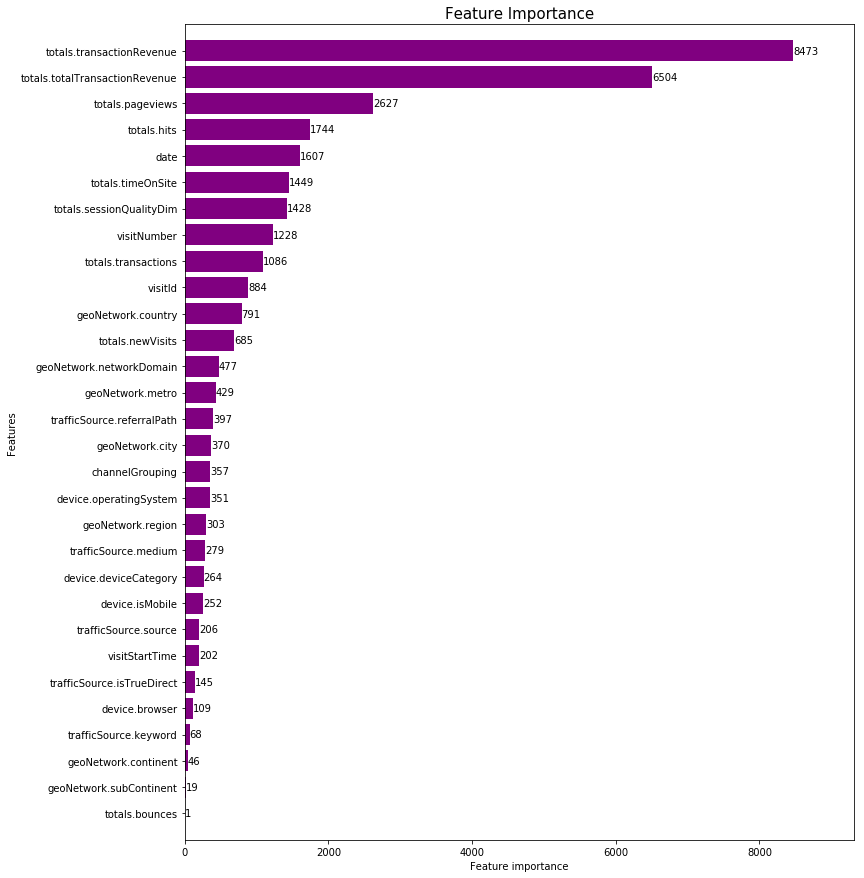

In [95]:
fig, ax = plt.subplots(figsize=(12,15))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax, color ='purple')
ax.grid(False)
plt.title("Feature Importance", fontsize=15)
plt.show()